# 实现CART回归树

## 目录
* 自己实现CART回归树
* 使用简单数据集进行验证
* 用波士顿房价数据集，进行手写代码与sklearn中的回归树的对比

## 实现CART回归树
并设计了几个剪枝参数  
* min_impurity_decrease 
* min_samples_split
* min_samples_leaf

In [1]:
import numpy as np
import graphviz
class DecisionTreeRegressor():
    
    def __init__(self,min_impurity_decrease=0,min_samples_split=2,min_samples_leaf=1):
        self.tree = None
        self.min_impurity_decrease = min_impurity_decrease
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
    
    def fit(self,X_train,y_train):
        
        
        def leafval(y_train):
            return y_train.mean()#返回叶子节点的值
        
        def Err(y_train):
            return y_train.var()*len(y_train)#返回叶子节点的总方差
        
        def bestsplit(X_train,y_train,min_impurity_decrease,min_samples_split,min_samples_leaf):
            """寻找最佳的切分特征，最佳的切分数据点。如果是叶子节点，则只返回叶子节点的值"""
            if len(set(y_train)) == 1 or len(y_train) < min_samples_split:#如果y_train只有一个值或者y种的样本量小于最小切分值，则不进行分支
                return float(leafval(y_train))
            bestErr = float("inf")
            bestFeature = -1
            bestSplitValue = -1
            for feature in range(X_train.shape[1]):
                colval = set(X_train[:,feature])
                for SplitValue in colval:
                    subleft_index = X_train[:,feature]<=SplitValue
                    yleft = y_train[subleft_index]
                    yright = y_train[~subleft_index]
                    if len(yleft) < min_samples_leaf or len(yright) < min_samples_leaf:
                        continue #如果子节点的个数小于设定值，则进行考虑
                    err = Err(yleft) + Err(yright)
                    if err < bestErr:
                        bestErr = err
                        bestFeature = feature
                        bestSplitValue = SplitValue
            if Err(y_train) - bestErr < min_impurity_decrease or bestFeature == -1:#方差误差下降的足够大或者无法分割
                return float(leafval(y_train))
            else:
                return bestFeature,bestSplitValue
        
        def createTree(X_train,y_train,min_impurity_decrease,min_samples_split,min_samples_leaf):
            
            res = bestsplit(X_train,y_train,min_impurity_decrease,min_samples_split,min_samples_leaf)
            if type(res) == float:
                return res
            else:
                tree = {}
                tree["SplitFeature"] = res[0]
                tree["SplitValue"] = res[1]
                left_index = X_train[:,res[0]] <= res[1]
                Xleft,Xright,yleft,yright = X_train[left_index,:],X_train[~left_index,:],y_train[left_index],y_train[~left_index]
                tree["LeftChild"] = createTree(Xleft,yleft,min_impurity_decrease,min_samples_split,min_samples_leaf)
                tree["RightChild"] = createTree(Xright,yright,min_impurity_decrease,min_samples_split,min_samples_leaf)
                return tree
        
        self.tree = createTree(X_train,y_train,min_impurity_decrease = self.min_impurity_decrease,min_samples_split = self.min_samples_split,min_samples_leaf = self.min_samples_leaf)
        return self            
                    
                
        
    def predict(self,X_test):
        RES = np.empty(len(X_test))
        for i in range(len(X_test)):
            RES[i] = self._predict(X_test[i])
        return RES

    def _predict(self,test_data):

        def __predict(tree,test_data):
            if type(tree) != dict: #如果tree只是一个值，则直接返回预测值
                return tree
            else:
                splitfeature = tree["SplitFeature"]
                splitvalue = tree["SplitValue"]
                if test_data[splitfeature] <= splitvalue:
                    return __predict(tree["LeftChild"],test_data)
                else:
                    return __predict(tree["RightChild"],test_data)

        assert self.tree is not None,"fit before predict"
        return __predict(self.tree,test_data)
            
    def draw_Tree(self):
        assert self.tree is not None,"fit before draw"
        def export_graphviz(tree,rootindex):
            if type(tree) == dict:
                text = "SplitFeature:{}\nSplitValue:{}".format(tree["SplitFeature"],tree["SplitValue"])
                text_node.append([str(rootindex),text])
                i[0]+=1
                text_edge.append([str(rootindex),str(i[0]),"<="])
                export_graphviz(tree["LeftChild"],i[0])
                
                i[0]+=1
                text_edge.append([str(rootindex),str(i[0]),">"])
                export_graphviz(tree["RightChild"],i[0])
            else:
                text_node.append([str(rootindex),'predict={}'.format(tree),'leaf'])
        
        
        text_node = []
        text_edge = []
        i=[1]
        export_graphviz(self.tree,i[0])
        dot = graphviz.Digraph(comment='tree')
        for line in text_node:
            if len(line)==2:
                dot.node(line[0],line[1],color="gold",shape="diamond")
            else:
                dot.node(line[0],line[1],color="lightyellow",shape='box',style="filled")
        for line in text_edge:
            dot.edge(line[0],line[1],line[2])
        dot.view()
    
    def score(self,X_test,y_test):
        predict = self.predict(X_test)
        return 1 - sum((y_test-predict)**2)/sum((y_test-y_test.mean())**2)

## 用简单数据集进行测试

In [2]:
import pandas as pd
data = np.array(pd.read_csv("ex00.txt",header=None,sep="\t"))
X = data[:,0][:,np.newaxis]
y = data[:,1]
import matplotlib.pyplot as plt
plt.scatter(X,y)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

<Figure size 640x480 with 1 Axes>

In [3]:
reg1 = DecisionTreeRegressor(min_impurity_decrease=1,min_samples_split=4)
reg1.fit(X,y)
reg2 = DecisionTreeRegressor(min_impurity_decrease=0.01)
reg2.fit(X,y)

In [4]:
reg1.tree

{'SplitFeature': 0,
 'SplitValue': 0.48813,
 'LeftChild': -0.04465028571428572,
 'RightChild': 1.0180967672413792}

In [5]:
reg1.draw_Tree()

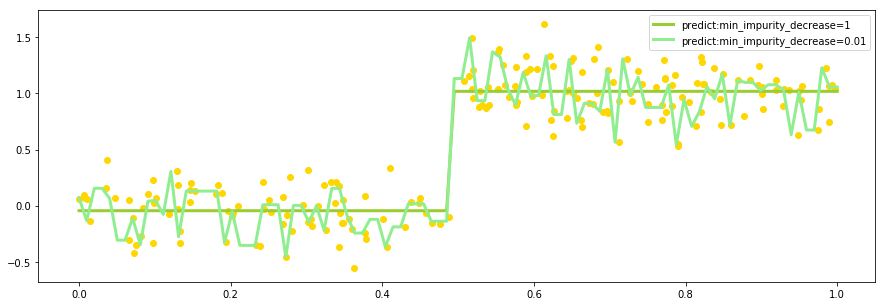

In [6]:
plt.figure(figsize=(15,5))
plt.scatter(X,y,color="gold")
X_plot = np.linspace(0,1,100).reshape(-1,1)
predict1 = reg1.predict(X_plot)
predict2 = reg2.predict(X_plot)
plt.plot(X_plot,predict1,color="yellowgreen",linewidth=3,label='predict:min_impurity_decrease=1')
plt.plot(X_plot,predict2,color="lightgreen",linewidth=3,label="predict:min_impurity_decrease=0.01")
plt.legend()
plt.show()

## 用波士顿房价来测试下

In [10]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
boston = load_boston()
X = boston.data
y = boston.target
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [11]:
reg = DecisionTreeRegressor(min_samples_leaf=13)
reg.fit(X_train,y_train)
predict = reg.predict(X_test)

In [12]:
from sklearn.metrics import r2_score
r2_score(y_test,predict)

0.8120685010445831

In [13]:
reg.draw_Tree()

In [14]:
from sklearn.tree import DecisionTreeRegressor
skl_reg = DecisionTreeRegressor(min_samples_leaf=13)
skl_reg.fit(X_train,y_train)
skl_reg.score(X_test,y_test)

0.8121215860629656

与sklearn中的DecisionTreeRegreesor做对比，两者基本无差